In [73]:
def sum(T,i,k):
    """Fonction qui somme les entiers du Tableau T
    
    Arguments:
        T {integer} -- Un tableau
        i {integer} -- indice i, souvent egale a 0
        k {integer} -- indice k, limite dans T et k inclu
    
    Returns:
        integer -- un entier
    """
    sum = 0
    for j in range(i,k+1):
        sum = sum + T[j]
    return sum

def sum_profile(T_1,T_2):
    """Fait la somme par indice commun des elements des 2 tableaux
    
    Arguments:
        T_1 {array} -- Le tableau representant le pool profile 1
        T_2 {array} -- Le tableau representant le pool profile 2
    Returns:
        array -- Le resultat de la somme des pool profile dont la longueur max des 2
    """
    p1 = len(T_1)
    p2 = len(T_2)
    Tr = [0]*(max(p1,p2))

   
    if p1 == 0 :
        return T_2
    
    if p2 == 0:
        return T_1

    for i in range(min(p1,p2)):
        Tr[i] = T_1[i]+T_2[i]
    if(p1 > p2):
        for i in range(p2,p1):
            Tr[i] = T_1[i]
    elif(p2 > p1):
        for i in range(p1,p2):
            Tr[i] = T_2[i]

    #print(T_1)
    #print(T_2)
    #print("som")
    #print(Tr)
    return Tr



def e_k(k):
    """ Un profile avec k element e^k(n) = (0........1) dont len(0........1) = n
    
    Arguments:
        k {integer} -- le nombre d'element
    
    Returns:
        array -- retourn le profile
    """
    l    = [0]*(k+1)
    l[k] = 1
    return l


def count (n,profile,s):
    """ L'algorithme de comptage
    
    Arguments:
        n {integer}     -- taille du spine a construire
        profile {array} -- la pool profile de debut
        s {integer}     -- level set rank(sibling rank)
    
    Returns:
        array -- Un tableau de couple (p,w). p est profile,w le poid du profile
    """
    d = {}
    k = len(profile)

    if n == 1 :
        som = sum(profile,0,k-1)
        S = (som*(som-1)) - s
        if S > 0:
            d = { tuple(e_k(k)):S}
    else:
        for i in range(n):
            if i == 0:
                d_0 = {():sum(profile,0,k-1)}
            else:
                d_0 = {}
                for k_0 in range(1,k):
                    d_0.update( count(i, profile[:k_0], profile[k_0]) )
            for (l,w_0) in d_0.items():
                p_prime  = sum_profile(profile,list(l))
                if n-1-i == 0:
                    d_1 = {():(-1 + sum(p_prime,0,k-1))}
                else:
                    d_1 = {}
                    for k_1 in range(1,k):
                        d_1.update(count(n-1-i,p_prime[:k_1],p_prime[k_1]))
                for (r,w_1) in d_1.items():
                    t = sum_profile(sum_profile(l,list(r)), e_k(k))
                    w = w_0*w_1
                    if tuple(t) in d.keys():
                        d[tuple(t)] = d[tuple(t)] + w
                    else:
                        d.update({tuple(t):w})
    return d

In [74]:
class Node:
    """ Un noeud avec : rang, index, fils-gauche, fils-droite
        {label 1 -> True}
        {label 0 -> False}
    """
    def __init__(self,label,rank,index,left,right):
        self.rank  = rank
        self.left  = left
        self.right = right
        self.index = index
        self.label = label
        self.printed = False

    def __eq__(self, value):
        return self.label == value.label
    
    def __ne__(self,value):
        return self.label != value.label
    
    def __hash__(self):
        return self.label

    def dot_ch(self):
        if self.printed == True:
            return ''
        self.printed = True #afficher qu'une fois
        dot = ''
        #for i in range(len(self.spine)):
        if self.label != 0 and self.label != 1:
            dot+= str(self.label)+"[label=x"+str(self.index)+"_"+str(self.label)+"];"
        if type(self.left) != int:
            dot+= str(self.label)+'->'+str(self.left.label)+'[style=dotted];'
            dot+= self.left.dot_ch()
        if type(self.right) != int:
            dot+= str(self.label)+'->'+str(self.right.label)+';'
            dot+= self.right.dot_ch()
        return dot
        
class Spine:
    """ Une classe pour construire un BDD
    """
    def __init__(self,k):
        self.spine      = [[] for i in range(k+1)]
        self.label      = 2
        self.profile    = [0]*(k+1)
        self.forbiden   = {}
        self.profile[0] = 2
        self.spine[0].append(Node(0,-1,0,-1,-1))
        self.spine[0].append(Node(1,-1,0,-1,-1))

    def print_spine(self):
        print('spine')
        for i in range(len(self.spine)):
            print('indexe='+str(i))
            for j in range(len(self.spine[i])):
                print("     "+str(self.spine[i][j].label))

    def print_profile(self):
        print('profile',end='')
        print(self.profile)
    
    def print_forbiden(self):
        print('forbiden')
        for i in self.forbiden.keys():
            print('index='+str(i))
            for x in self.forbiden[i].keys():
                print('     x='+str(x.label)+'(index='+str(x.index)+') -> y-values=',end='')
                for y in self.forbiden[i][x]:
                    print(str(y.label)+'(index='+str(y.index)+')',end=',')
                print()

    def root(self):
        return self.spine[len(self.spine)-1][0]

    def size(self):
        return sum(self.profile,0,len(self.profile)-1)

    def variable(self):
        return len(self.profile)-1

    def affiche(self):
        
        g = (("arbre")
        +" k="
        +str(self.root().index)
        +" n="
        +str(sum(self.profile,0,len(self.profile)-1)))
        
        dot = 'digraph {graph [label="'+g+'", labelloc=t, fontsize=30];\n'
        dot += '1[label=Vrai];0[label=Faux];'
        return dot + self.root().dot_ch() + '}'

    def stocke(self):
        dot = self.affiche()

        fic = open("arbre_taille_" 
        + str(self.size()) 
        + "_variable_" 
        + str(self.variable())
        +".dot", 'w')

        fic.write(dot)
        fic.close()
        return None
        
    def unrank_singleton(self,rank):
        """ Suivre l'ordre < pour le rank
        """
        r = rank
        for i in range(len(self.spine)):
            for j in range(len(self.spine[i])):
                node = self.spine[i][j]
                if r == 0:
                    return node
                r = r - 1
        raise Exception('unrank_singleton fail index')
    
    def unrank_pair(self,rank,k):
        print("unrank_pair rank="+str(rank)+" k="+str(k))
        #self.print_forbiden()
        #self.print_profile()
        r = rank
        for i in range(k):
            #print(" spinelen="+str(len(self.spine[i])))
            for a in range(len(self.spine[i])):
                n = self.spine[i][a]
                for j in range(0,k):
                    for b in range(len(self.spine[j])):
                        x = n
                        y = self.spine[j][b]
                        #print("x="+str(x.label)+" y="+str(y.label)+" i_k="+str(j)+' rank='+str(r))
                        
                        if x == y:
                            continue
                        
                        constructed = True
                        if  (k not in self.forbiden) or (x not in self.forbiden[k]) or (y not in self.forbiden[k][x]):
                            constructed = False
                            
                        if constructed:
                            r = r - 1
                            continue
                        
                        if not constructed:
                            r = r - 1
                        
                        if r < 0:
                            print (x.label,y.label)
                            return (x,y)
        raise Exception('unrank_pair fail')
        
    def get_rank(self,i):
        return i.rank
        
    def add_node(self,rank,index,left,right):
        n = Node(self.label,rank,index,left,right)
        self.spine[index].append(n)
        self.label += 1
        self.profile[index] += 1
        if index not in self.forbiden:
            self.forbiden[index] = {}
        if n.left not in self.forbiden[index]:
            self.forbiden[index][n.left] = []
        self.forbiden[index][n.left].append(n.right)
        return n
        
    def get_profile(self):
        return self.profile

In [75]:
def gen_bdd(rank, n, k):
    """ Pour generer un bdd et cette fonction appele generate
        Arguments:
            
            rank{integer} -- le rang de l'arbre a generer
            
            n{integer}    -- la taille de l'abre dont True et False font partie
            
            k{integer}    -- nombre de variables
    """
    print('gen_bdd...')
    spine = Spine(k)
    r    = rank
    p    = [0]*k
    p[0] = 2
    d = count(n-2,p,0)
    print('counted '+str(d))
    for (t,w) in d.items():
        r = r - w
        if r < 0:
            r = r + w
            generate(r,n-2,spine,t)
            print('profile finale '+str(spine.profile))
            #print('spine finale   '+str(spine.spine))
            return spine
    raise Exception('Pas BDD')
        
def generate(rank, n, spine, p_target):
    #spine.print_forbiden()
    #spine.print_profile()
    print('generate rank='+str(rank)+" k="+str(len(p_target)-1)+" n="+str(n)+" targ="+str(list(p_target)))
    k = len(p_target)-1
    if n == 0 :
        node = spine.unrank_singleton(rank)
        print('***()***unrank singleton k='+str(node.index)+'('+str(node.label)+')')
        return node
    if n == 1 :
        lo,hi = spine.unrank_pair(rank,k)
        print("****!unrank_pair!** node k="+str(k)+" left="+str(lo.index)+'('+str(lo.label)+')'+" right="+str(hi.index)+'('+str(hi.label)+')')
    else:
        print('#######decomposition')
        i,r0,l,r1,h = decompose(rank,n,spine,p_target)
        lo = generate(r0,i,spine,l)
        if n-1-i == 0:
            hi = spine.unrank_singleton(r1)
            if hi == lo:
                hi = generate(r1-1, n-1-i, spine, h)
        else:
            hi = generate(r1, n-1-i, spine, h)
        print("No equals "+str(hi==lo))
        print(str(n))
        print("****!decomposed!*** node k="+str(k)+" left="+str(lo.index)+'('+str(lo.label)+')'+" right="+str(hi.index)+'('+str(hi.label)+')')
    #print('adding node rank='+str(rank)+" k="+str(k))
    node = spine.add_node(rank,k,lo,hi)
    print("label k="+str(node.label))
    return node

def decompose(rank, n, spine, p):
    #print("decompose looking ",end="")
    #print(p)
    p_target = list(p)
    r = rank
    s = spine.get_profile()
    k = len(p_target)-1
    q = s[:k]
    q[0] = 2
    i = n-1
    while i >= 0:
        #print('decompose '+str(i))
        if i == 0:
            d0 = {(): sum(q,1,k-1)+2}
        else:
            d0 = {}
            for k0 in range(1,k):
                d0.update(count(i,q[:k0],q[k0]))
        for (l,w0) in d0.items():
            q_prime = sum_profile(q,l)
            if n-1-i == 0 :
                d1 = {():sum(q_prime,1,k-1)+1}
            else:
                d1 = {}
                for k1 in range(1,k):
                    d1.update(count(n-1-i,q_prime[:k1],q_prime[k1]))
            for (h,w1) in d1.items():
                t = sum_profile(sum_profile(e_k(k),list(l)),list(h))
                w = w0*w1
                if t == p_target:
                    #print('decompose match ',end="")
                    #print(t)
                    if w > 0:
                        r = r - w
                    if r < 0:
                        r  = r + w
                        r0 = r % w0
                        r1 = r // w0
                        #print('w0='+ str(w0))
                        #print('w1='+ str(w1))
                        return (i,r0,l,r1,h)
        i = i - 1
    raise Exception('decompose: fail')


In [76]:
#rank -- rang
#n    -- taille de l'arbre True et False compris
#k    -- nombre de variable, c'est-a-dire l'index max

rank = 310
n    = 7
k    = 4

In [77]:
#gen_bdd(rank,n,k)

graph = gen_bdd(rank,n,k)

gen_bdd...
counted {(0, 2, 1, 1, 1): 584, (0, 1, 2, 1, 1): 1256, (0, 2, 2, 0, 1): 74, (0, 1, 1, 2, 1): 1112, (0, 2, 0, 2, 1): 74, (0, 0, 2, 2, 1): 74}
generate rank=310 k=4 n=5 targ=[0, 2, 1, 1, 1]
#######decomposition
generate rank=6 k=2 n=2 targ=[0, 1, 1]
#######decomposition
generate rank=0 k=-1 n=0 targ=[]
***()***unrank singleton k=0(0)
generate rank=1 k=1 n=1 targ=[0, 1]
unrank_pair rank=1 k=1
1 0
****!unrank_pair!** node k=1 left=0(1) right=0(0)
label k=2
No equals False
2
****!decomposed!*** node k=2 left=0(0) right=1(2)
label k=3
generate rank=3 k=3 n=2 targ=[0, 1, 0, 1]
#######decomposition
generate rank=0 k=1 n=1 targ=[0, 1]
unrank_pair rank=0 k=1
0 1
****!unrank_pair!** node k=1 left=0(0) right=0(1)
label k=4
generate rank=2 k=-1 n=0 targ=[]
***()***unrank singleton k=1(2)
No equals False
2
****!decomposed!*** node k=3 left=1(4) right=1(2)
label k=5
No equals False
5
****!decomposed!*** node k=4 left=2(3) right=3(5)
label k=6
profile finale [2, 2, 1, 1, 1]


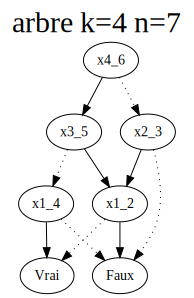

In [78]:
from graphviz import Source

src = Source(graph.affiche())
src